In [1]:
#!pip install vitaldb

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import vitaldb
import warnings
warnings.filterwarnings('ignore')

In [5]:
liste_ids = pd.read_excel("liste id.xlsx")
liste_ids = liste_ids.sort_values(by='caseid')

In [6]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")

In [7]:
LSTM_NODES = 16  # Number of cells in LSTM

In [12]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 2  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment
x1=[]
# maximum number of cases
for caseid in liste_ids['caseid'].tolist()[100:101]:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['Solar8000/ART_MBP'], 2)
    plet = vitaldb.load_case(caseid, ['SNUADC/PLETH'], 2)
    hr = vitaldb.load_case(caseid, ['Solar8000/PLETH_HR'], 2)

    arts[arts<30]=np.nan
    case_valid_mask = ~np.isnan(arts)
    arts = arts[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]
    
    #Filtering artifacts
    arts=arts[(arts>=20) & (arts <=180)].flatten()
    hr=hr[(hr>=30) & (hr <=160)].flatten()
    plet=plet[(plet>=-10) & (plet<=100)].flatten()



    case_sample = 0
    case_event = 0

    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]
        seg2x = plet[i:i + SRATE * 20]
        seg2y = plet[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]
        seg3x=hr[i:i + SRATE * 20]
        seg3y = hr[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        if np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 150).any():
            valid = False
        elif (segy > 150).any():
            valid = False
        elif (np.abs(np.diff(segx)) > 50).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 50).any():  # abrupt change -> noise
            valid = False


        # 2 sec moving avg
        n = 2 * SRATE
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        
        
        x.append(seg2x)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)

        if valid:
            case_sample += 1
            if evt:
                case_event += 1
      
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    #if len(np.unique(c)) >= MAX_CASES:
    #    break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array

x = np.array(x)
y = np.array(y)
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]

print(x.shape)
print(y.shape)

print(y.astype(int).sum())

loading 1123...

445 samples 26 (5.8 %) events
(0, 1, 1)
(477,)
28


In [129]:
x[0].shape

(40,)

In [118]:
from sklearn.model_selection import train_test_split

# Assuming you have x, y, and c variables containing your data
# Assuming valid_mask is defined earlier in your code

# Splitting the data into training and testing sets
train_x_valid, test_x_valid, train_y_valid, test_y_valid = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

# # Assuming caseids is a list of case IDs corresponding to your data
# ncase = len(caseids)
# ntest = len(test_y_valid)
# ntrain = len(train_y_valid)
# caseids_train = caseids[:ntrain]
# caseids_test = caseids[-ntest:]

# # Creating masks for train and test sets
# train_mask = np.isin(c, caseids_train)
# test_mask = np.isin(c, caseids_test)

# # Filtering out invalid samples from the test dataset
# test_x = x[test_mask]
# test_y = y[test_mask]
# test_c = c[test_mask]

# # Filtering out invalid samples from the training dataset
# train_x_valid = train_x_valid[train_mask & valid_mask]
# train_y_valid = train_y_valid[train_mask & valid_mask]

testname = '{} cases {} ahead, batch size = {}, total {} samples, train {} ({} events, {:.1f}%), test {} ({} events, {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname


'100 cases 1 ahead, batch size = 256, total 7998 samples, train 6398 (353 events, 5.5%), test 1600 (88 events, 5.5%)'

In [119]:
train_y_valid=train_y_valid.astype(int)

In [120]:
train_y_valid.shape

(6398,)

In [121]:
train_x_valid.shape

(6398, 40, 1)

In [122]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras.optimizers import Adam 

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.3, epochs=100, batch_size=BATCH_SIZE,
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True)
                            ])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 0.6863 - accuracy: 0.6149 - auc_13: 0.4703
Epoch 1: val_loss improved from inf to 0.65331, saving model to output\weights.hdf5
18/18 [==============================] - 5s 80ms/step - loss: 0.6854 - accuracy: 0.6224 - auc_13: 0.4741 - val_loss: 0.6533 - val_accuracy: 0.9427 - val_auc_13: 0.5667
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 0.6354 - accuracy: 0.9010 - auc_13: 0.5883
Epoch 2: val_loss improved from 0.65331 to 0.61580, saving model to output\weights.hdf5
18/18 [==============================] - 1s 32ms/step - loss: 0.6347 - accuracy: 0.9017 - auc_13: 0.5939 - val_loss: 0.6158 - val_accuracy: 0.9427 - val_auc_13: 0.4936
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 0.5940 - accuracy: 0.9403 - auc_13: 0.5483
Epoch 3: val_loss improved from 0.61580 to 0.57139, saving model to output\weights.hdf5
18/18 [==============================] - 1s 33ms/step - loss: 0.5932

2996

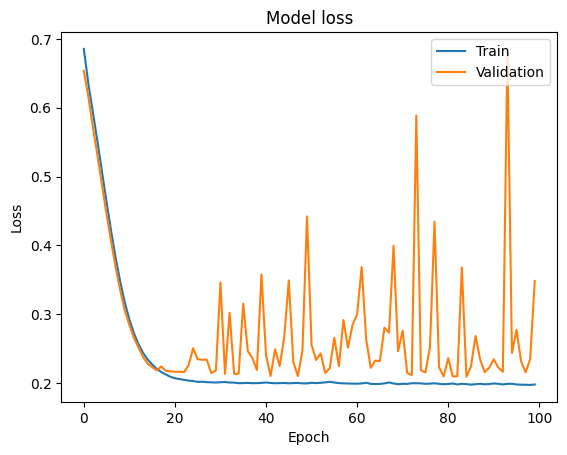

In [123]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('{}/loss_plot.png'.format(tempdir))
plt.show()


In [124]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(tempdir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(tempdir))
plt.close()

50/50 [==============================] - 1s 8ms/step
auroc=0.704, auprc=0.146 acc=0.945, F1=0.000, PPV=nan, NPV=94.5, TN=1512, fp=0, fn=88, TP=0


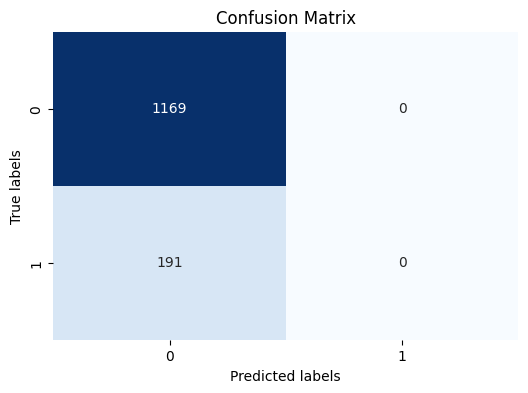

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have calculated the confusion matrix
conf_matrix = confusion_matrix(test_y_valid, test_y_pred > thval)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('{}/confusion_matrix.png'.format(tempdir))
plt.show()
